# **Detección de Fraude en Transacciones de Tarjetas de Crédito**


### **Definición del Problema**

El objetivo del proyecto es desarrollar un modelo de predicción de fraude para una institución financiera como un banco. El fraude representa una pérdida significativa de ingresos para los bancos y es importante detectarlo de manera oportuna. El modelo se construirá usando datos históricos de transacciones y se aplicará a nuevas transacciones para identificar posibles fraudes.

#### **Dataset**
- **Fuente**: [Kaggle - credit-card-fraud-detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

El conjunto de datos contiene las transacciones realizadas con tarjetas de crédito en septiembre de 2013 por titulares de tarjetas europeos, este conjunto de datos presenta las transacciones que ocurrieron en dos días, donde tenemos 492 fraudes de 284,807 transacciones. El conjunto de datos está muy desequilibrado, la clase positiva (fraudes) representa el 0,172% de todas las transacciones.

Contiene solo variables de entrada numéricas que son el resultado de una transformación PCA. **Características V1, V2, ... V28 son los componentes principales que se obtienen con PCA**, las únicas características que no se han transformado con PCA son **Tiempo** y **Cantidad**.

- `Tiempo`: contiene los segundos transcurridos entre cada transacción y la primera transacción en el conjunto de datos. 
- `Cantidad`: cantidad de la transacción
- `Clase`: variable objetivo que toma el valor 1 en caso de fraude y 0 en caso contrario.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("./data/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# No tenemos valores perdidos en el dataset
perdidos = data.isnull().sum()
porcentaje = (100*data.isnull().sum()/data.count())
pd.concat([perdidos, porcentaje], axis=1, keys=['Valores perdidos', 'Porcentaje']).transpose()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Valores perdidos,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Porcentaje,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Tenemos algunas filas duplicadas
duplicados = data.duplicated().sum()
duplicados

1081

In [6]:
# Vemos cuales son las dimensiones del dataframe antes de eliminar los duplicados
data.shape

(284807, 31)

In [7]:
# Eliminamos los duplicados y comprobamos que se ha realizado correctamente
data = data.drop_duplicates(keep = False)
data.shape

(282953, 31)

#### **AED**

¿Cuál es el porcentaje de transacciones fraudulentas en el dataset?

In [8]:
#Calculamos el porcentaje de transacciones fraudulentas
nfraudulentas = data['Class'].sum()
ntotal = data['Class'].count()
pfraudulentas = 100 * nfraudulentas / ntotal

# Muestra el porcentaje de transacciones fraudulentas
print(f'Número de operaciones fraudulentas --> {nfraudulentas}')
print(f'Número total de operaciones --> {ntotal}')
print(f'Porcentaje de operaciones fraudulentas --> {pfraudulentas:.2f}%')

Número de operaciones fraudulentas --> 460
Número total de operaciones --> 282953
Porcentaje de operaciones fraudulentas --> 0.16%


¿Cuál es el importe medio de las transacciones fraudulentas?

In [9]:
# Calcula el importe medio de las transacciones fraudulentas
mediafraudulentas = data[data.Class == 1]['Amount'].mean()

# Muestra el importe medio de las transacciones fraudulentas
print(f'Importe medio de las transacciones fraudulentas --> {mediafraudulentas:.2f}€')

Importe medio de las transacciones fraudulentas --> 124.05€


¿Cuántas transacciones fraudulentas hay en comparación con las no fraudulentas?

In [10]:
# Cuenta el número de transacciones fraudulentas y no fraudulentes
nnofraudulentas = ntotal - nfraudulentas

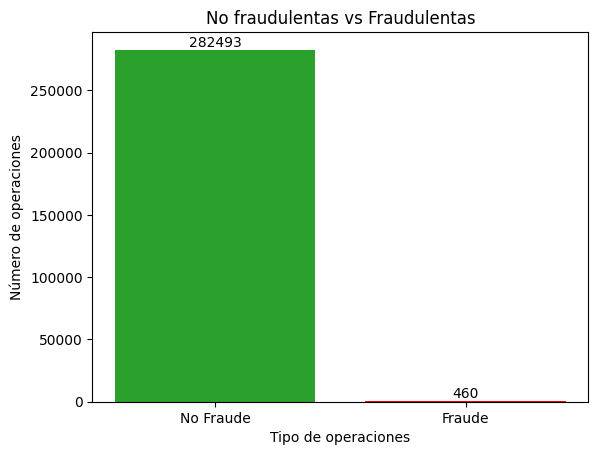

In [11]:
# Muestra la distribución de las transacciones fraudulentas con respecto de las no fraudulentas
fig, ax = plt.subplots()
gbarras = ax.bar(['No Fraude', 'Fraude'], [nnofraudulentas, nfraudulentas], color=['tab:green', 'red'])
ax.set_title('No fraudulentas vs Fraudulentas')
ax.set_ylabel('Número de operaciones')
ax.set_xlabel('Tipo de operaciones')

for tipo in gbarras:
    altura = tipo.get_height()
    ax.text(tipo.get_x() + tipo.get_width()/2, altura, f'{altura}', ha='center', va='bottom')
fig.show()

¿Cuál es la distribución de los importes de las transacciones fraudulentas?

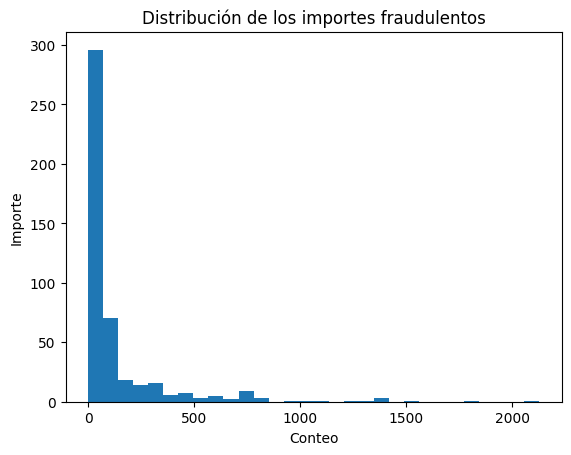

In [12]:
# Separa los datos de transacciones fraudulentas
data_fraudulentas = data[data.Class == 1]['Amount']
data_fraudulentas.head()

# Muestra la distribución de los importes de las transacciones fraudulentas
fig, ax = plt.subplots()
ghistograma = ax.hist(data_fraudulentas, bins=30)
ax.set_title('Distribución de los importes fraudulentos')
ax.set_ylabel('Importe')
ax.set_xlabel('Conteo')
fig.show()

#### **División del dataset en datos de entrenamiento y test**

In [13]:
y = data["Class"]
X = data.drop("Class", axis=1) 

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.20, random_state=42)

In [14]:
scaler = StandardScaler()

X_train['Amount'] = scaler.fit_transform(X_train['Amount'].values.reshape(-1, 1))
X_val['Amount'] = scaler.fit_transform(X_val['Amount'].values.reshape(-1, 1))
X_test['Amount'] = scaler.transform(X_test['Amount'].values.reshape(-1, 1))

#### **Random Forest**

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix, recall_score, precision_recall_fscore_support

from utils import print_score

In [16]:
modelo = RandomForestClassifier(random_state=42)
modelo.fit(X_train, y_train)

print_score(modelo, X_train, y_train, X_val, y_val, train=True)
print_score(modelo, X_train, y_train, X_val, y_val, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                       0           1  accuracy      macro avg   weighted avg
precision       0.999994    1.000000  0.999994       0.999997       0.999994
recall          1.000000    0.996564  0.999994       0.998282       0.999994
f1-score        0.999997    0.998279  0.999994       0.999138       0.999994
support    180798.000000  291.000000  0.999994  181089.000000  181089.000000
_______________________________________________
Confusion Matrix: 
 [[180798      0]
 [     1    290]]

Validation Result:
Accuracy Score: 99.96%
_______________________________________________
CLASSIFICATION REPORT:
                      0          1  accuracy     macro avg  weighted avg
precision      0.999712   0.934426  0.999625      0.967069      0.999612
recall         0.999912   0.814286  0.999625      0.907099      0.999625
f1-score       0.999812   0.870229  0.999625      0.935020      0.9996